# Mise en place

In [ ]:
from sklearn.cluster import KMeans, SpectralClustering
import numpy as np
import pylab as plt
import networkx as nx
import pandas as pd
from datetime import datetime, date, time
import cvxpy as cp
from scipy.optimize import minimize
from numpy.linalg import norm, multi_dot
from sklearn.metrics import normalized_mutual_info_score
import copy
import scipy.io
import time
import sys, os
import itertools
from collections import deque
from datetime import datetime, timedelta

# MIT

This codes extracts the data of the RealityMining dataset.




In [ ]:
#start_date = 1094601600 #First day of classes in 04-05 academic year
#end_date = 1133740800 #Last day of classes in 04-05 academic year

def hasNumeric(obj, field):
   try:
      obj[field][0][0]
      return True
   except:
      return False


def getNumeric(obj, field):
   return obj[field][0][0]


def hasArray(obj, field):
   try:
      obj[field][0]
      return True
   except:
      return False


def getArray(obj, field):
   return obj[field][0]


def validSubjects(allSubjects):
   return [s for s in allSubjects if hasNumeric(s,'mac') and hasNumeric(s,'my_hashedNumber')]


# idDicts: subjects -> {int: subject}, {float: (int, subject)}, {int: (int, subject)}
# First hash is contiguousId: subjectObject
# second hash is macAddress: contiguousId, subjectObject
# third hash is hashedNumber: contiguousId, subjectObject
# because the id dictionaries reference the subject object, we can replace
# the array of subject objects with these dictionaries.
def idDicts(subjects):
   return (dict((i, s) for (i,s) in enumerate(subjects)),
      dict((getNumeric(s,'mac'), (i, s)) for (i,s) in enumerate(subjects)),
      dict((getNumeric(s, 'my_hashedNumber'), (i, s)) for (i,s) in enumerate(subjects)))


def allCommEvents(idDictionary):
   events = []
   for subjectId, subject in idDictionary.items():
      if hasArray(subject, 'comm'):
         events.extend([(subjectId, event) for event in getArray(subject, 'comm')])

   print("%d total comm events" % len(events))
   return events


# extract those call events which are voice calls and only between
# two members of the study.
def callsWithinStudy(commEvents, hashNumDict):
   calls = [(subjectId, e) for (subjectId, e) in commEvents if getArray(e, 'description') == "Voice call"
                                             and getNumeric(e, 'hashNum') in hashNumDict]
   print("%d total calls within study" % len(calls))
   return calls


def convertDatetime(dt):
   return datetime.fromordinal(int(dt)) + timedelta(days=dt%1) - timedelta(days=366) - timedelta(hours=5)


def processCallEvents(callEvents, hashNumDict):
   processedCallEvents = []

   for subjectId, event in callEvents:
      direction = getArray(event, 'direction')
      duration = 0 if direction == 'Missed' else getNumeric(event, 'duration')
      date = convertDatetime(getNumeric(event, 'date'))
      hashNum = getNumeric(event, 'hashNum')
      otherPartyId = hashNumDict[hashNum][0]

      eventAsDict = {'subjectId': subjectId,
                      'direction': direction,
                      'duration': duration,
                      'otherPartyId': otherPartyId,
                      'date': date}
      processedCallEvents.append(eventAsDict)

   print("%d call event dictionaries" % len(processedCallEvents))
   return processedCallEvents


def inRange(dateRange, timevalue):
   start, end = dateRange
   unixTime = int(time.mktime(timevalue.timetuple()))
   return start <= unixTime <= end


def filterByDate(dateRange, events):
   filteredCalls = [e for e in events if inRange(dateRange, e['date'])]
   print("%d calls after filtering by date" % len(filteredCalls))
   return filteredCalls


def writeCallEvents(callEventDicts, filename):
   with open(filename, 'w') as outfile:
      outfile.write('subjectId\totherPartyId\tduration\tdirection\tdate\n')
      for d in callEventDicts:
         values = [d['subjectId'], d['otherPartyId'], d['duration'], d['direction'], d['date']]
         line = '\t'.join(("%s" % (v,)) for v in values)
         outfile.write('%s\n' % line)


def createPhoneCallDataset(idDictionaries):
   startDate = 1095984000
   endDate = 1105142400

   # this data contains the subject records as well
   idDict, macDict, hashNumDict = idDictionaries

   print("Extracting intra-study calls...")
   calls = callsWithinStudy(allCommEvents(idDict), hashNumDict)

   print("Converting call events to a reasonable format...")
   convertedCallEvents = processCallEvents(calls, hashNumDict)

   print("Filtering calls within the given date range...")
   callsToWrite = filterByDate((startDate, endDate), convertedCallEvents)

   print("Writing the calls to reality-mining-calls.txt...")
   writeCallEvents(callsToWrite, 'reality-mining-calls.txt')


# survey values are either numeric or numpy.nan, so we need special
# functions to account for means/maxes involving nan.
def mean(x, y):
   if numpy.isnan(x):
      return mean(0, y)
   if numpy.isnan(y):
      return mean(x, 0)

   return float(x + y) / 2


def myMax(x, y):
   if numpy.isnan(x):
      return myMax(0, y)
   if numpy.isnan(y):
      return myMax(x, 0)

   return max(x,y)


# For simplicity: take the avg of estimates, and the max of the friendship reporting
def getSurveyResponse(network, id1, id2):
   friends = myMax(network['friends'][id1][id2], network['friends'][id2][id1])
   inLabProximity = mean(network['lab'][id1][id2], network['lab'][id2][id1])
   outLabProximity = mean(network['outlab'][id1][id2], network['outlab'][id2][id1])

   return (id1, id2, friends, inLabProximity, outLabProximity)


def writeSurveyEvents(surveyRecords, filename):
   with open(filename, 'w') as outfile:
      outfile.write('id1\tid2\tclose-friends?\tinlab-proximity\toutlab-proximity\n')
      for values in surveyRecords:
         line = '\t'.join(("%s" % (v,)) for v in values)
         outfile.write('%s\n' % line)


def createFriendshipDataset(networkObj, idDictionaries):
   idDict, macDict, hashNumDict = idDictionaries

   networkIdDict = dict((i, (hashNum, hashNumDict[hashNum][0]))
         for i,hashNum in enumerate(getArray(networkObj, 'sub_sort'))
         if hashNum in hashNumDict) # this guarantees the subject is valid

   convertId = lambda i: networkIdDict[i][1]

   print("Creating network survey dataset (friendship/proximity/close friends)")
   networkSurvey = [getSurveyResponse(networkObj,i,j)
         for i,j in itertools.combinations(networkIdDict.keys(), 2)]

   print("Converting ids")
   convertedNetworkSurvey = [(convertId(x[0]), convertId(x[1]), x[2], x[3], x[4])
         for x in networkSurvey if x[2] != 0 or x[3] != 0 or x[4] != 0]

   print("Writing the survey data to reality-mining-survey.txt")
   writeSurveyEvents(convertedNetworkSurvey, 'reality-mining-survey.txt')


# turn each (date, tower) pair into a (dateInterval, tower) pair
# so we can compute the amount of time spent within one tower range,
# or the overlap of two people in the same tower rage.
def makeCellTowerIntervals(subject):
   events = subject['locs']
   dt = convertDatetime
   return [((dt(events[i][0]), dt(events[i+1][0])), events[i][1])
           for i in range(len(events) - 1) if events[i][1] > 0] # condition ensures there was signal


def dateIntervalOverlap(dtint1, dtint2):
   start1, end1 = dtint1
   start2, end2 = dtint2

   if start1 <= start2 <= end1:
      return (start2, min(end1, end2))
   elif start2 <= start1 <= end2:
      return (start1, min(end1, end2))
   else:
      return None


def listProximityEvents(intervals1, intervals2):
   if len(intervals1) == 0 or len(intervals2) == 0:
 #     print("Found an empty interval list?")
      return []

   D1, D2 = deque(intervals1), deque(intervals2)
   events = deque()

 #  print('Processing new pairs of intervals')
   dateInterval1, towerId1 = D1.popleft()
   dateInterval2, towerId2 = D2.popleft()
   while len(D1) > 0 and len(D2) > 0:
      if dateInterval2[0] >= dateInterval1[1]:
         dateInterval1, towerId1 = D1.popleft()
      elif dateInterval1[0] >= dateInterval2[1]:
         dateInterval2, towerId2 = D2.popleft()
      else:
         if towerId1 == towerId2:
            theOverlap = dateIntervalOverlap(dateInterval1, dateInterval2)
            if (theOverlap[1] - theOverlap[0]).total_seconds() > 1:  
               events.append((theOverlap, towerId1))
               #print('Found a match! %s, %s at tower %s' % (theOverlap[0], theOverlap[1], towerId1))

         if dateInterval1[0] < dateInterval2[0]:
            dateInterval1, towerId1 = D1.popleft()
         else:
            dateInterval2, towerId2 = D2.popleft()

   return events


def writeProximityEvents(proxEventsDict, filename):
   with open(filename, 'w') as outfile:
      outfile.write('id1\tid2\tcellTower\tstart\tend\n')
      for k in proxEventsDict:
         id1, id2 = k
         for event in proxEventsDict[k]:
            values = [id1, id2, event[1], event[0][0], event[0][1]]
            line = '\t'.join(("%s" % (v,)) for v in values)
            outfile.write('%s\n' % line)


def createCellTowerDataset(idDictionaries):
   idDict, macDict, hashNumDict = idDictionaries

   print("Making cell tower intervals.")
   cellTowerIntervals = dict((i, makeCellTowerIntervals(idDict[i])) for i in idDict)

   print("Computing cell tower proximity events.")
   proximityEvents = dict(((i, j), listProximityEvents(cellTowerIntervals[i], cellTowerIntervals[j]))
         for i,j in itertools.combinations(cellTowerIntervals.keys(), 2))

   print("Writing proximity events to reality-mining-proximity.txt")
   writeProximityEvents(proximityEvents, 'reality-mining-proximity.txt')


if __name__ == "__main__":
   matlab_filename = sys.argv[1]
   print("Loading in matlab data - this takes a while and about 2gb memory")
   matlab_obj = scipy.io.loadmat("realitymining.mat")
   print("Done loading matlab data.")

   print('Extracting valid subjects and creating id dictionaries.')
   subjects = validSubjects(matlab_obj['s'][0])
   idDictionaries = idDicts(subjects)

   #uncomment the following lines to get the Dataset you want

   #createFriendshipDataset(matlab_obj['network'][0][0], idDictionaries)
   #createPhoneCallDataset(idDictionaries)
   #createCellTowerDataset(idDictionaries)

   print("Cleaning up...")



Loading in matlab data - this takes a while and about 2gb memory
Done loading matlab data.
Extracting valid subjects and creating id dictionaries.
Cleaning up...


In [ ]:
#création of the labels


labels=['empty']*90

for i in range(90):
  labels[i]=subjects[i]['my_affil'][0][0]

labels=np.array(labels)


In [ ]:
#Création de la matrice d'appels
calls=np.loadtxt('reality-mining-calls.txt',delimiter='\t', skiprows=1, dtype=float, usecols=(0,1))

In [ ]:
#n nombre de personnes dans l'étude
n=len(calls)
matrix_calls=np.zeros((90,90))

for i in range(n):
    if not(calls[i,0]==calls[i,1]):
      matrix_calls[int(calls[i,0]), int(calls[i,1])]=1
      matrix_calls[int(calls[i,1]), int(calls[i,0])]=1

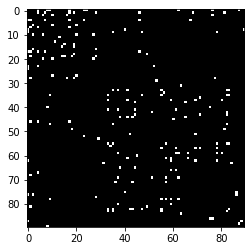

In [ ]:
plt.imshow(matrix_calls, cmap='gray',vmin = 0, vmax = 1)

In [ ]:
# Proximity matrix
proximity=np.loadtxt('reality-mining-proximity.txt',delimiter='\t', skiprows=1, dtype=float, usecols=(0,1))
n=len(proximity)
matrix_proximity=np.zeros((90,90))

for i in range(n):
      matrix_proximity[int(proximity[i,0]), int(proximity[i,1])]=1
      matrix_proximity[int(proximity[i,1]),int(proximity[i,0])]=1

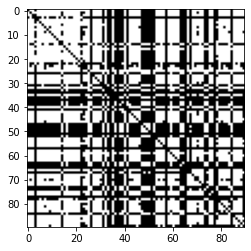

In [ ]:
plt.imshow(matrix_proximity, cmap='gray',vmin = 0, vmax = 1)

In [ ]:
#friendship matrix
friendship=np.loadtxt('reality-mining-survey.txt',delimiter='\t', skiprows=1, dtype=float, usecols=(0,1,2))

In [ ]:
matrix_friendship=np.zeros((90,90))
n=len(friendship)

for i in range(n):
  if friendship[i,2]==1: 
    matrix_friendship[int(friendship[i,0]),int(friendship[i,1])]=1
    matrix_friendship[int(friendship[i,1]),int(friendship[i,0])]=1

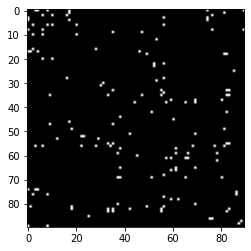

In [ ]:
plt.imshow(matrix_friendship, cmap='gray',vmin = 0, vmax = 1)

In [ ]:
all_labels=all_labels[0:105]

In [ ]:
np.savetxt('true_labels.txt',all_labels,fmt="%s")

#Cora

La cellule suivante est la seule à modifier si on veut régler le nombre de données (=nombre d'articles) qu'on veut avoir.

In [ ]:
#pour avoir environ 2*N_max données
N_max= 20

In [ ]:
data_dir = os.path.expanduser("~/data/cora")

In [ ]:
# On récupères les edges, les papiers du dataset. 

edgelist = pd.read_csv("cora.cites", sep='\t', header=None, names=["target", "source"])
edgelist["label"] = "cites"

In [ ]:
edgelist.sample(frac=1).head(5)  #ici on a la table des citations, le papier 'source' cite le papier 'target'

,target,source,label
4771,289780,1153784,cites
2818,33907,1136814,cites
251,887,1111304,cites
2622,28359,35863,cites
1598,8703,434,cites


In [ ]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv("cora.content", sep='\t', header=None, names=column_names)

In [ ]:
node_data  # les colonnes w_ décrivent l'occurence des mots 

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,...,w_1424,w_1425,w_1426,w_1427,w_1428,w_1429,w_1430,w_1431,w_1432,subject
31336,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1061127,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
1106406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
13195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
37879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128975,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
1128977,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
1128978,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
117328,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Case_Based


In [ ]:
# les différents sujets des papiers

set(node_data["subject"])
{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

In [ ]:
#Je prends juste les articles dans les catégories Genetic_Algorithms,Neural_Networks et Probabilistic_Methods
names = ['Genetic_Algorithms']
df1=node_data[node_data.subject.isin(names)]
#df1=df.sample(n = 30)

names = ['Neural_Networks']
df2=node_data[node_data.subject.isin(names)]
#df2=df.sample(n = 20)

names = ['Probabilistic_Methods']
df3=node_data[node_data.subject.isin(names)]
#df3=df.sample(n = 40)

In [ ]:
frames = [df1, df2, df3]
df = pd.concat(frames)
df=df.sort_index(axis = 0, ascending = True)

In [ ]:
#le nom des lignes qui correspondent aux catégories qu'on a gardé

row_names=df.index.values

In [ ]:
#on fait d'abord le graphe des citations
citations=np.array(edgelist)

#on enlève la dernière colonne
citations=citations[:,:-1]

In [ ]:
#on en choisit des lignes où le cité et le citant sont dans les catégories qu'on a choisies (pour ne pas avoir un graphe de citations trop vide)
#À la fin on a environ 2*N_max articles

choix=np.linspace(0,len(citations)-1,len(citations))
C=np.zeros((N_max,2))
n=0
while n<N_max:
  c=int(np.random.choice(choix))
  x=citations[c][0]
  y=citations[c][1]
  if (x in row_names) and (y in row_names):
    u=np.where(row_names==x)[0]
    v=np.where(row_names==y)[0]
    if not [int(u),int(v)] in C:
      C[n][0]=int(u)
      C[n][1]=int(v)
      n+=1

In [ ]:
# on fait une liste des indices des lignes gardées
row_names2=[]
for i in range(len(C)):
  if not row_names[int(C[i][0])] in row_names2:
    row_names2.append(row_names[int(C[i][0])])
  if not row_names[int(C[i][1])] in row_names2:
    row_names2.append(row_names[int(C[i][1])])
  
print("nombre d'articles gardés={}".format(len(row_names2)))

nombre d'articles gardés=40


In [ ]:
row_names2=np.array(np.sort(row_names2))

In [ ]:
#on crée la matrice des citations
m=len(row_names2)
cite=np.zeros((m,m))
for i in range(len(citations)):
  if (citations[i][0] in row_names2) and (citations[i][1] in row_names2):
    ind1=0
    ind2=0
    for j in range(len(row_names2)):
      if row_names2[j]==citations[i][0]:
        ind1=j
      if row_names2[j]==citations[i][1]:
        ind2=j
    cite[ind1,ind2]=1
    cite[ind2,ind1]=1

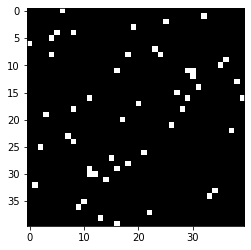

In [ ]:
plt.figure()
plt.imshow(cite, cmap='gray',vmin = 0, vmax = 1)
plt.savefig("cite.pdf")

In [ ]:
#Maintenant on regarde les histogrammes de mot
row_names2=list(row_names2)

In [ ]:
# on sélectionne seulement les articles gardés pour les citations
df=df.loc[row_names2]

In [ ]:
#on fait la cosine similarity
data=df.to_numpy()
data=data[:,:-1]
m,n=data.shape
#A adjacency matric
A=np.zeros((m,m))

for i in range(m):
  for j in range(m):
    x=data[i]
    y=data[j]
    A[i,j]=np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y)) 

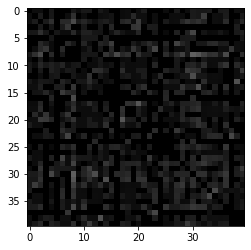

In [ ]:
#on attribue les valeurs 0 ou 1 et on met la digonale à 0 (ou 1)
for i in range(len(A)):
  for j in range(len(A)):
    if i==j:
      A[i,j]=0
    elif A[i,j]<0.1:
      A[i,j]=1
    else: 
      A[i,j]=0
    
plt.imshow(A, cmap='gray',vmin = 0, vmax = 1)

In [ ]:
#liste des labels
subject=df.loc[:,'subject']
subject=np.array(subject)


In [ ]:
#on sauve les matrices au format .txt
np.savetxt('words.txt',A,fmt='%.2f')
np.savetxt('cite.txt',cite,fmt='%.2f')
np.savetxt("subject.txt", subject, delimiter=" ", newline = "\n", fmt="%s")